## Introduction to Project
- Data on sales from book retailers from 1992 to late 2019 was gathered from the Federal Reserve Economic Data (FRED).
- The goal of this project was to use the book sales history to create a model that can forecast future sales into the end of 2020.
- A model was created using an LSTM recurrent neural network, which was trained on a subset of the data and the results were compared to a test set.
- Once satisfactory performance was achieved, a second LSTM model was trained using the entire data set, which was then used to project book sales of retailers into 2020.

In [289]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

## Data
Units:  Millions of Dollars, Not Seasonally Adjusted

Frequency:  Monthly

Information about the Monthly Retail Trade Survey can be found on the Census website at https://www.census.gov/retail/mrts/about_the_surveys.html

Suggested Citation:
U.S. Census Bureau, Retail Sales: Book Stores [MRTSSM451211USN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/MRTSSM451211USN, January 8, 2020.

In [290]:
df = pd.read_csv('MRTSSM451211USN.csv',parse_dates=True,index_col='DATE')
df.columns = ['Sales']

In [291]:
df

,Sales
DATE,
1992-01-01,790
1992-02-01,539
1992-03-01,535
1992-04-01,523
1992-05-01,552
...,...
2019-06-01,672
2019-07-01,646
2019-08-01,1226


In [292]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
Sales    334 non-null int64
dtypes: int64(1)
memory usage: 5.2 KB


**Sales (in millions of USD) from 1992 to 2019**

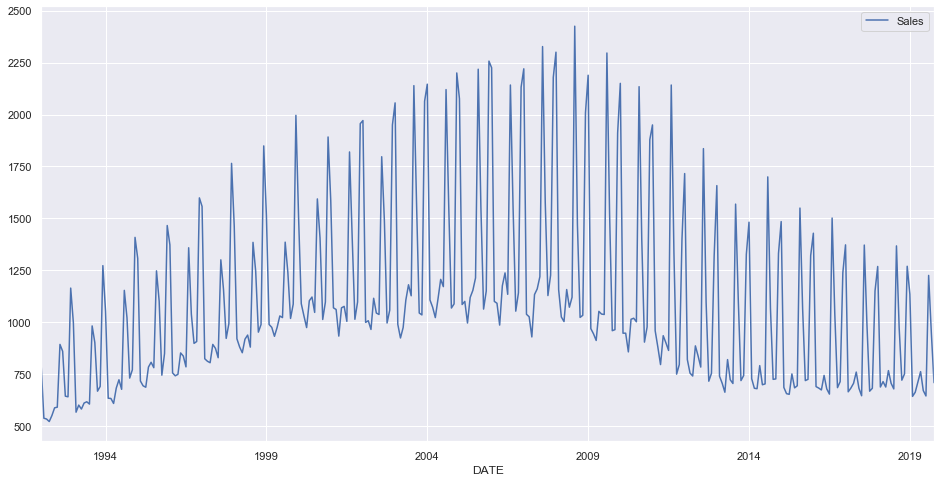

In [293]:
df.plot(figsize=(16,8))
plt.show()

**Sales in the most recent 36 months**

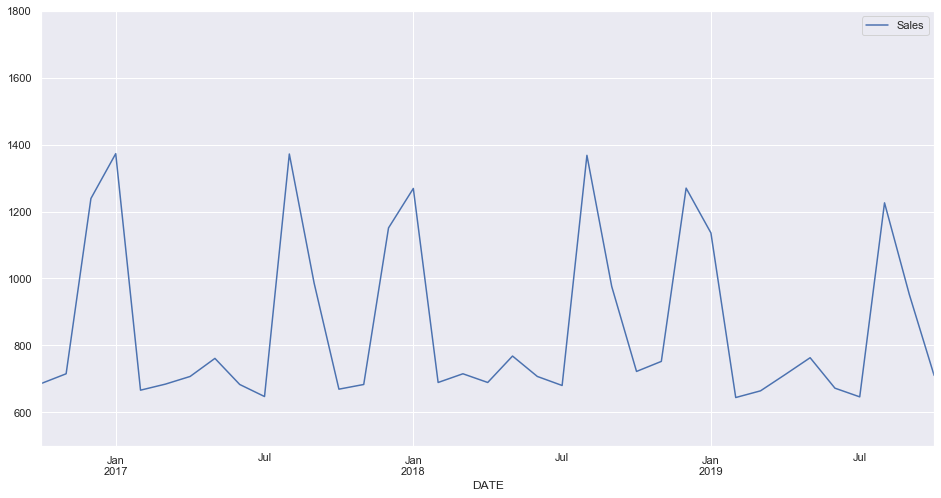

In [294]:
df.plot(figsize=(16,8))
plt.xlim('2016-10-01','2019-10-01')
plt.ylim(500,1800)
plt.show()

**Notes on book sales**
- The sales trend appears to have seasonality.
- Sales appear to peak in the two month window of December/January as well as in August.
- Peak of August sales typically last for only that month with sales dramatically decreasing in September.
- All remaining months have roughly the same value in sales.

In [295]:
len(df)

334

**Note:** Since we have clear seasonality in a yearly cycle, we want to include at least 12 months (12 data points) for our test size. 18 months was selected as it covers over a year to capture the seasonality trend.

In [296]:
test_size = 18
test_ind = len(df) - test_size

In [297]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [298]:
train

,Sales
DATE,
1992-01-01,790
1992-02-01,539
1992-03-01,535
1992-04-01,523
1992-05-01,552
...,...
2017-12-01,1151
2018-01-01,1269
2018-02-01,689


In [299]:
test

,Sales
DATE,
2018-05-01,768
2018-06-01,707
2018-07-01,680
2018-08-01,1368
2018-09-01,976
2018-10-01,722
2018-11-01,752
2018-12-01,1270
2019-01-01,1136


## Scaling Data

In [300]:
from sklearn.preprocessing import MinMaxScaler

In [301]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [302]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [303]:
# Let's redefine to go 12 months back and then predict the next month
length = 12
generator = TimeseriesGenerator(data=train_scaled,targets=train_scaled,
                               length=length,batch_size=1)

In [304]:
# Previewing the first batch
X,y = generator[0]

In [305]:
print(f'Given the Array: \n{X}')
print(f'Next Predicted Value: \n {y}')

Given the Array: 
[[[0.14037855]
  [0.0084122 ]
  [0.00630915]
  [0.        ]
  [0.01524711]
  [0.03470032]
  [0.0362776 ]
  [0.19505783]
  [0.17770768]
  [0.06414301]
  [0.06256572]
  [0.33753943]]]
Next Predicted Value: 
 [[0.24973712]]


## Creating the Model

In [306]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense
from tensorflow.keras.callbacks import EarlyStopping

In [307]:
# Only one features (sales) is being used for this model
n_features = 1

In [308]:
model = Sequential()
model.add(LSTM(units=100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [309]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [310]:
early_stop = EarlyStopping(monitor='val_loss',patience=3)

In [311]:
validation_genenerator = TimeseriesGenerator(data=test_scaled,targets=test_scaled,
                                            length=length,batch_size=1)

In [312]:
# Fitting model
model.fit_generator(generator,epochs=20,validation_data=validation_genenerator,callbacks=[early_stop])

Epoch 1/20
304/304 [==============================] - 6s 18ms/step - loss: 0.0504 - val_loss: 0.0121
Epoch 2/20
304/304 [==============================] - 6s 19ms/step - loss: 0.0407 - val_loss: 0.0103
Epoch 3/20
304/304 [==============================] - 6s 18ms/step - loss: 0.0240 - val_loss: 0.0084
Epoch 4/20
304/304 [==============================] - 5s 18ms/step - loss: 0.0117 - val_loss: 0.0023
Epoch 5/20
304/304 [==============================] - 6s 18ms/step - loss: 0.0063 - val_loss: 0.0011
Epoch 6/20
304/304 [==============================] - 6s 19ms/step - loss: 0.0048 - val_loss: 6.8227e-04
Epoch 7/20
304/304 [==============================] - 5s 18ms/step - loss: 0.0044 - val_loss: 4.2727e-04
Epoch 8/20
304/304 [==============================] - 6s 19ms/step - loss: 0.0041 - val_loss: 0.0020
Epoch 9/20
304/304 [==============================] - 5s 18ms/step - loss: 0.0042 - val_loss: 3.4972e-04
Epoch 10/20
304/304 [==============================] - 5s 18ms/step - loss: 0.0

In [313]:
losses = pd.DataFrame(model.history.history)
losses.index = losses.index + 1

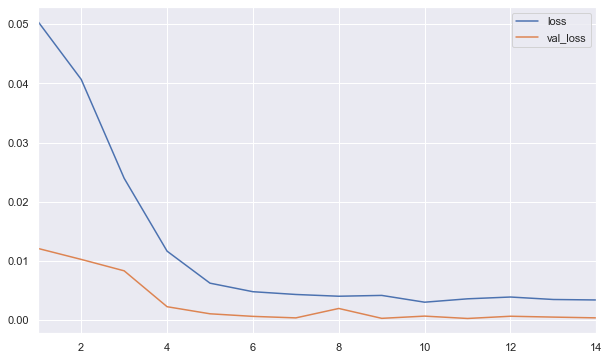

In [320]:
losses.plot(figsize=(10,6))
plt.xlim(1,14)
plt.show()

**Notes:**
- Best results of the model was achieved after 11 epochs.
- No improvements in validation loss was obtained with a patience of 3.
- Several other iterations for training this model was attempted (e.g. varying test size (18-24), batch length size(12-18), and number of LSTM units (100-150).
- The parameters found above yielded the best results according to the evaluation below, achieving the lowest root mean square error.

## Evaluation of Model to Test Data

In [315]:
test_predictions = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [316]:
true_predictions = scaler.inverse_transform(test_predictions)

In [317]:
test['Predictions'] = true_predictions

E:\Users\Charles\Anaconda3\envs\mytfenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [318]:
test

,Sales,Predictions
DATE,,
2018-05-01,768,714.788303
2018-06-01,707,665.931385
2018-07-01,680,649.010172
2018-08-01,1368,1310.781320
2018-09-01,976,949.257092
2018-10-01,722,672.266320
2018-11-01,752,671.561298
2018-12-01,1270,1111.055922
2019-01-01,1136,1259.176021


## Actual Sales vs. Predicted Sales from Model

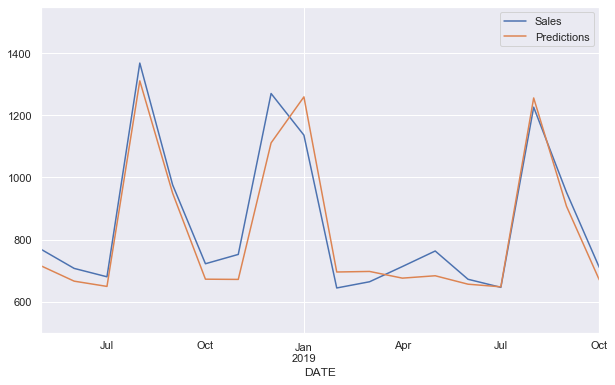

In [319]:
test.plot(figsize=(10,6))
plt.ylim(500,1550)
plt.show()

In [321]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(test['Sales'],test['Predictions']))

64.59487142133888

Given the order of magnitude of sales, a root mean square error of 64.6 seems like an acceptable value for this model.

## Forecasting into the end of 2020

In [322]:
# All data will now be used to train a new model.
full_scaler = MinMaxScaler()
full_data_scaled = full_scaler.fit_transform(df)

In [323]:
length = 12
generator_full_data = TimeseriesGenerator(full_data_scaled,full_data_scaled,
                               length=length,batch_size=1)

In [324]:
model = Sequential()
model.add(LSTM(units=100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

# 11 epochs was selected since the previous model above yielded the lowest loss after 11 epochs.
model.fit_generator(generator_full_data,epochs=11)

Epoch 1/11
322/322 [==============================] - 6s 18ms/step - loss: 0.0465
Epoch 2/11
322/322 [==============================] - 6s 18ms/step - loss: 0.0316
Epoch 3/11
322/322 [==============================] - 6s 18ms/step - loss: 0.0180
Epoch 4/11
322/322 [==============================] - 6s 18ms/step - loss: 0.0062
Epoch 5/11
322/322 [==============================] - 6s 20ms/step - loss: 0.0039
Epoch 6/11
322/322 [==============================] - 6s 18ms/step - loss: 0.0039
Epoch 7/11
322/322 [==============================] - 6s 18ms/step - loss: 0.0034
Epoch 8/11
322/322 [==============================] - 6s 18ms/step - loss: 0.0030
Epoch 9/11
322/322 [==============================] - 6s 18ms/step - loss: 0.0030
Epoch 10/11
322/322 [==============================] - 6s 18ms/step - loss: 0.0032
Epoch 11/11
322/322 [==============================] - 6s 18ms/step - loss: 0.0031


In [326]:
forecast = []
# We will forecast into the next 14 months to give us sales predictions through the end of 2020.
periods = 14

first_eval_batch = full_data_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [327]:
forecast = scaler.inverse_transform(forecast)

In [328]:
forecast

array([[ 768.92241818],
       [1320.53584588],
       [1193.05088377],
       [ 707.3288849 ],
       [ 707.4081575 ],
       [ 734.40672654],
       [ 772.02802211],
       [ 702.78197646],
       [ 687.36789167],
       [1264.63565528],
       [ 985.9061718 ],
       [ 738.84780592],
       [ 785.1976749 ],
       [1378.34815842]])

In [329]:
forecast_index = pd.date_range(start='2019-11-01',periods=periods,
                              freq='MS')

In [330]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                          columns=['Forecast'])

**Forecasted sales through the end of 2020 using our model**

In [331]:
forecast_df

,Forecast
2019-11-01,768.922418
2019-12-01,1320.535846
2020-01-01,1193.050884
2020-02-01,707.328885
2020-03-01,707.408157
2020-04-01,734.406727
2020-05-01,772.028022
2020-06-01,702.781976
2020-07-01,687.367892
2020-08-01,1264.635655


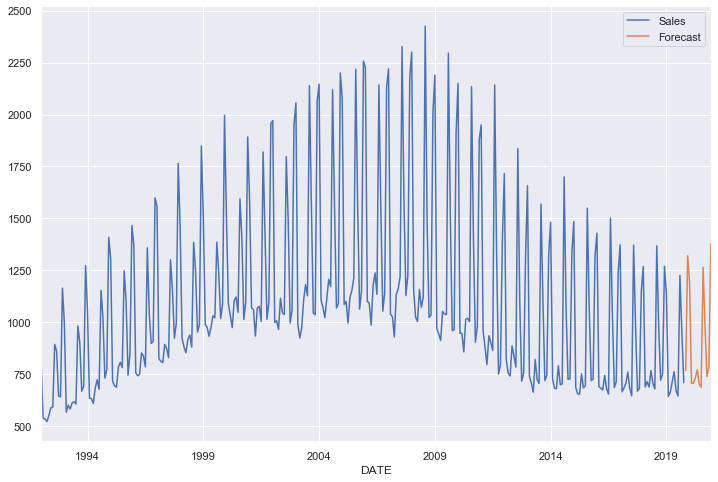

In [332]:
ax = df.plot(figsize=(12,8))
forecast_df.plot(ax=ax)
plt.show()

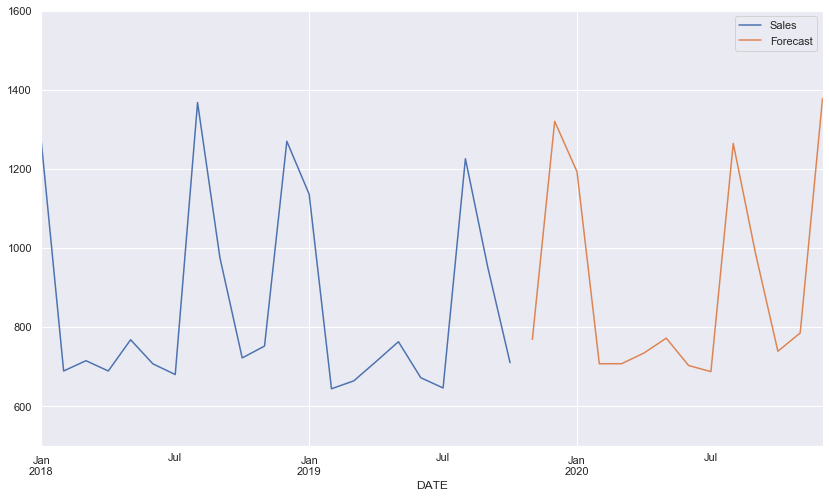

In [333]:
ax = df.plot(figsize=(14,8))
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')
plt.ylim(500,1600)
plt.show()

**Final Thoughts:**
- Projecting out to the end of 2020, we can still expect the same trend in seasonality with book sales peaking twice per year: the December/January peak as well as the August sales peak.
- Interestingly, although predicted sales in late 2019 and all of 2020 follow the same seasonal trend, the overall sales for that predicted time period appears to be sligthly greater than years past.
- Perhaps an upswing in book sales will begin to take place, climbing back up to where overall sales were the highest in 2004-2009.
- Alternatively, sales may begin to plateau after 2019 and the overall decline starting from 2009 has finally stopped for the time being.
- It is difficult to project the overall trend that far out into the future with the data available.